# 期末综合练习（1）

### 设计一个CNN网络，训练自定义图像数据集的分类操作。 通过优化网络结构与超参数、正则化、数据增强等各种手段，尽可能提高准确率。（要求自建模型，形式不限，不能使用预定义模型）
Dataset Context：<BR>
This is image data of Natural Scenes around the world.<BR>
Dataset Content：<BR>
This Data contains around 25k images of size 96x96 distributed under 6 categories.<BR>
{'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2,
'mountain' -> 3,  'sea' -> 4, 'street' -> 5 }
<BR>
    
#### 要求：
1)利用callback将最佳模型保存到文件(注意：在"save"目录下建立以自己学号命名的子目录，然后在该子目录下保存文件)。显示loss曲线和accuracy曲线。<BR>
2)读取最佳模型进行指标评估并显示结果，展示混淆矩阵。<BR>
3)尝试展示典型图片的热力图<BR>

#### 考核办法：
1）程序功能完成度<BR>
2）score = model.evaluate(testset)<BR>
计算得到的准确率为指标，达到0.8为及格成绩起点，0.9优秀<BR>

In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,2048)

Fri Jun 16 09:10:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 40%   44C    P2   111W / 350W |   7975MiB / 24268MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   

# Prepare the dataset

In [2]:
#查看图片尺寸结构
import numpy as np
from torchvision import transforms,utils
from torch.utils import data
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline

train_data = datasets.ImageFolder('data/project/seg_train/seg_train')
size = []
for i in range(len(train_data)):
    size.append(train_data[i][0].size[0])
a,t = np.unique(size, return_counts=True)    # 每个元素在旧列表里各自出现了几次
print('train_data:',a,t)

test_data = datasets.ImageFolder('data/project/seg_test/seg_test')
size = []
for i in range(len(train_data)):
    size.append(train_data[i][0].size[0])
a,t = np.unique(size, return_counts=True)    # 每个元素在旧列表里各自出现了几次
print('test_data:',a,t)

train_data: [150] [14034]
test_data: [150] [14034]


# Create the dataset and show

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: data/project/seg_train/seg_train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(150, 150), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 3000
    Root location: data/project/seg_test/seg_test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(150, 150), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
tensor([1, 1, 5, 2, 0, 1, 5, 5, 0, 5, 3, 2, 5, 3, 0, 0, 5, 2, 0, 2, 1, 0, 3, 3,
        3, 0, 5, 4, 1, 5, 1, 2, 5, 2, 1, 3, 4, 2, 3, 0, 2, 5, 1, 2, 5, 0, 5, 0,
        4, 5, 4, 4, 4, 

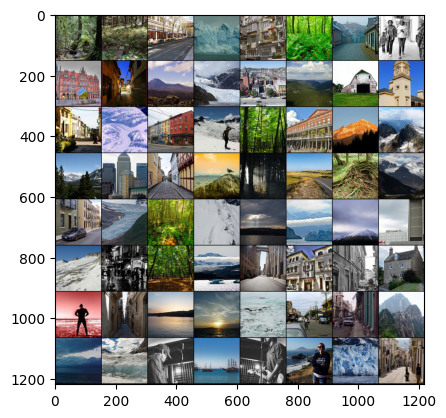

In [3]:
my_trans = transforms.Compose([
    transforms.RandomResizedCrop(size= (150,150),scale=(0.9,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
BATCH_SIZE = 64
train_data = datasets.ImageFolder('data/project/seg_train/seg_train',transform=my_trans)
print(train_data)
test_data = datasets.ImageFolder('data/project/seg_test/seg_test',transform=my_trans)
print(test_data)
train_loader = data.DataLoader(train_data,batch_size= BATCH_SIZE,shuffle=True)
test_loader = data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)
for i_batch,img in enumerate(train_loader):
    if i_batch == 0:
        # img代表一个列表：img[0]代表数据，img[1]代表标签
        print(img[1])
        fig = plt.figure()
        # B x C x H x W 输入就是这种形式
        grid = utils.make_grid(img[0],normalize=True)
        # [C x H x W] 改变成 [H × W × C]
        plt.imshow(grid.numpy().transpose((1,2,0)))
        plt.show()

In [4]:
print(train_data.classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Define the Res-block

In [5]:
import torch
from torch import nn
# 定义残差架构
class Residual(nn.Module): 
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, X):
        Y = nn.GELU()(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        Y = self.gelu(Y)
        #Y = self.dropout(Y)
        return Y
            
def Resnet_block(input_channels, num_channels, num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

# Define the model

In [6]:
#定义模型结构
class My_Resmodel(nn.Module): 
    def __init__(self, types):
        super().__init__()
        self.b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.GELU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*Resnet_block(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*Resnet_block(64, 128, 2))
        self.b4 = nn.Sequential(*Resnet_block(128, 256, 2))
        self.b5 = nn.Sequential(*Resnet_block(256, 512, 2))
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(512, types)
        self.dropout = nn.Dropout(0.3)
        self.attlinear = nn.Linear(512, 128)
        self.attlinear2 = nn.Linear(128, types)
        self.attention =nn.Linear(128, 128)

    
    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X_ = self.b5(X)
        X = self.pool(X_)
        X = self.flatten(X)
        X = self.dropout(X)
        X = self.attlinear(X)
        X = self.dropout(X)
        attention_weights = nn.Softmax(dim=1)(self.attention(X))
        X = torch.mul(attention_weights, X)
        X = self.attlinear2(X)
        #X = self.linear(X)
        return (X,X_)
                                     

# Show the model and init

In [7]:
model = My_Resmodel(types = 6)
print(model)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
model.apply(init_weights)
loss = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4,eps=1e-8 , weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch = 40

My_Resmodel(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (gelu): GELU()
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

# Training

Warning：非必要请不要运行训练代码。  
该模型较大，在后期已经出现了训练资源不足，OOM无法调试的现象，请老师助教见谅。

In [8]:
from sklearn.metrics import  precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
def train(model, train_iter, valid_iter, loss, optimizer,epoch):  
    loss_min = 1
    val_ac = 0.8
    total_ac_train = []
    total_ac_val = []
    total_loss_train = []
    total_loss_val = []

    #model.load_state_dict(torch.load('save/3200100259/model_saved.pth'))
    model.to(device) 
    
    for i in range(epoch):
        model.train()# 将模型设置为训练模式
        print('Running epoch %d ...'%(i+1))
        n_iter_t = 0
        n_iter_v = 0
        l_epoch_t = 0
        l_epoch_v = 0
        a_epoch_t = 0
        a_epoch_v = 0
        
        for X, y in train_iter:
            n_iter_t += 1
            X = X.to(device)
            y = y.to(device)
            # 计算梯度并更新参数
            y_hat,_ = model(X)
            l = loss(y_hat, y)
            l_epoch_t += l.item()
            
            y_pred = torch.argmax(y_hat,1).to('cpu') 
            a_epoch_t += accuracy_score(y_true=y.to('cpu'), y_pred=y_pred)
            #re = recall_score(y_true=y.to('cpu'), y_pred=y_pred,average='macro')
            
            # 使用PyTorch内置的优化器和损失函数
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
        #记录训练过程数据
        l_mean_t = l_epoch_t/n_iter_t
        a_mean_t = a_epoch_t/n_iter_t
        total_loss_train.append(l_mean_t)
        total_ac_train.append(a_mean_t)
        
        #验证代码
        model.eval()
        for X, y in valid_iter:
            n_iter_v += 1
            X = X.to(device)
            y = y.to(device)
            # 计算梯度并更新参数
            y_hat,_ = model(X)
            l = loss(y_hat, y)
            l_epoch_v += l.item()
            
            y_pred = torch.argmax(y_hat,1).to('cpu') 
            a_epoch_v += accuracy_score(y_true=y.to('cpu'), y_pred=y_pred)
            #re = recall_score(y_true=y.to('cpu'), y_pred=y_pred,average='macro')
        
        #记录验证过程数据
        l_mean_v = l_epoch_v/n_iter_v
        a_mean_v = a_epoch_v/n_iter_v
        total_loss_val.append(l_mean_v)
        total_ac_val.append(a_mean_v)
        
        #保存最优模型
        #if l_mean_v < loss_min:
            #loss_min = l_epoch_v
        if a_mean_v > val_ac:
            val_ac = a_mean_v
            torch.save(model.state_dict(),'save/3200100259/model_saved.pth')
            print('model saved!')
            
        #scheduler.step(l_mean_v)
        print('End epoch %d, Current loss = %.2f/%.2f, Current Acc = %.2f/%.2f'%(i+1,l_mean_t,l_mean_v,a_mean_t,a_mean_v))
    return (total_loss_train,total_ac_train,total_loss_val,total_ac_val)
        
loss_train,ac_train,loss_val,ac_val = train(model, train_loader, test_loader, loss, optimizer, epoch)


Running epoch 1 ...
End epoch 1, Current loss = 1.40/1.08, Current Acc = 0.39/0.50
Running epoch 2 ...
End epoch 2, Current loss = 1.11/0.87, Current Acc = 0.53/0.64
Running epoch 3 ...
End epoch 3, Current loss = 0.99/0.85, Current Acc = 0.57/0.67
Running epoch 4 ...
End epoch 4, Current loss = 0.92/0.82, Current Acc = 0.63/0.73
Running epoch 5 ...
End epoch 5, Current loss = 0.82/0.68, Current Acc = 0.69/0.80
Running epoch 6 ...
model saved!
End epoch 6, Current loss = 0.74/0.57, Current Acc = 0.72/0.83
Running epoch 7 ...
End epoch 7, Current loss = 0.70/0.58, Current Acc = 0.72/0.82
Running epoch 8 ...
model saved!
End epoch 8, Current loss = 0.66/0.48, Current Acc = 0.74/0.86
Running epoch 9 ...
model saved!
End epoch 9, Current loss = 0.62/0.49, Current Acc = 0.75/0.86
Running epoch 10 ...
End epoch 10, Current loss = 0.63/0.54, Current Acc = 0.75/0.83
Running epoch 11 ...
End epoch 11, Current loss = 0.60/0.61, Current Acc = 0.76/0.80
Running epoch 12 ...
model saved!
End epoch 

# Show the training process

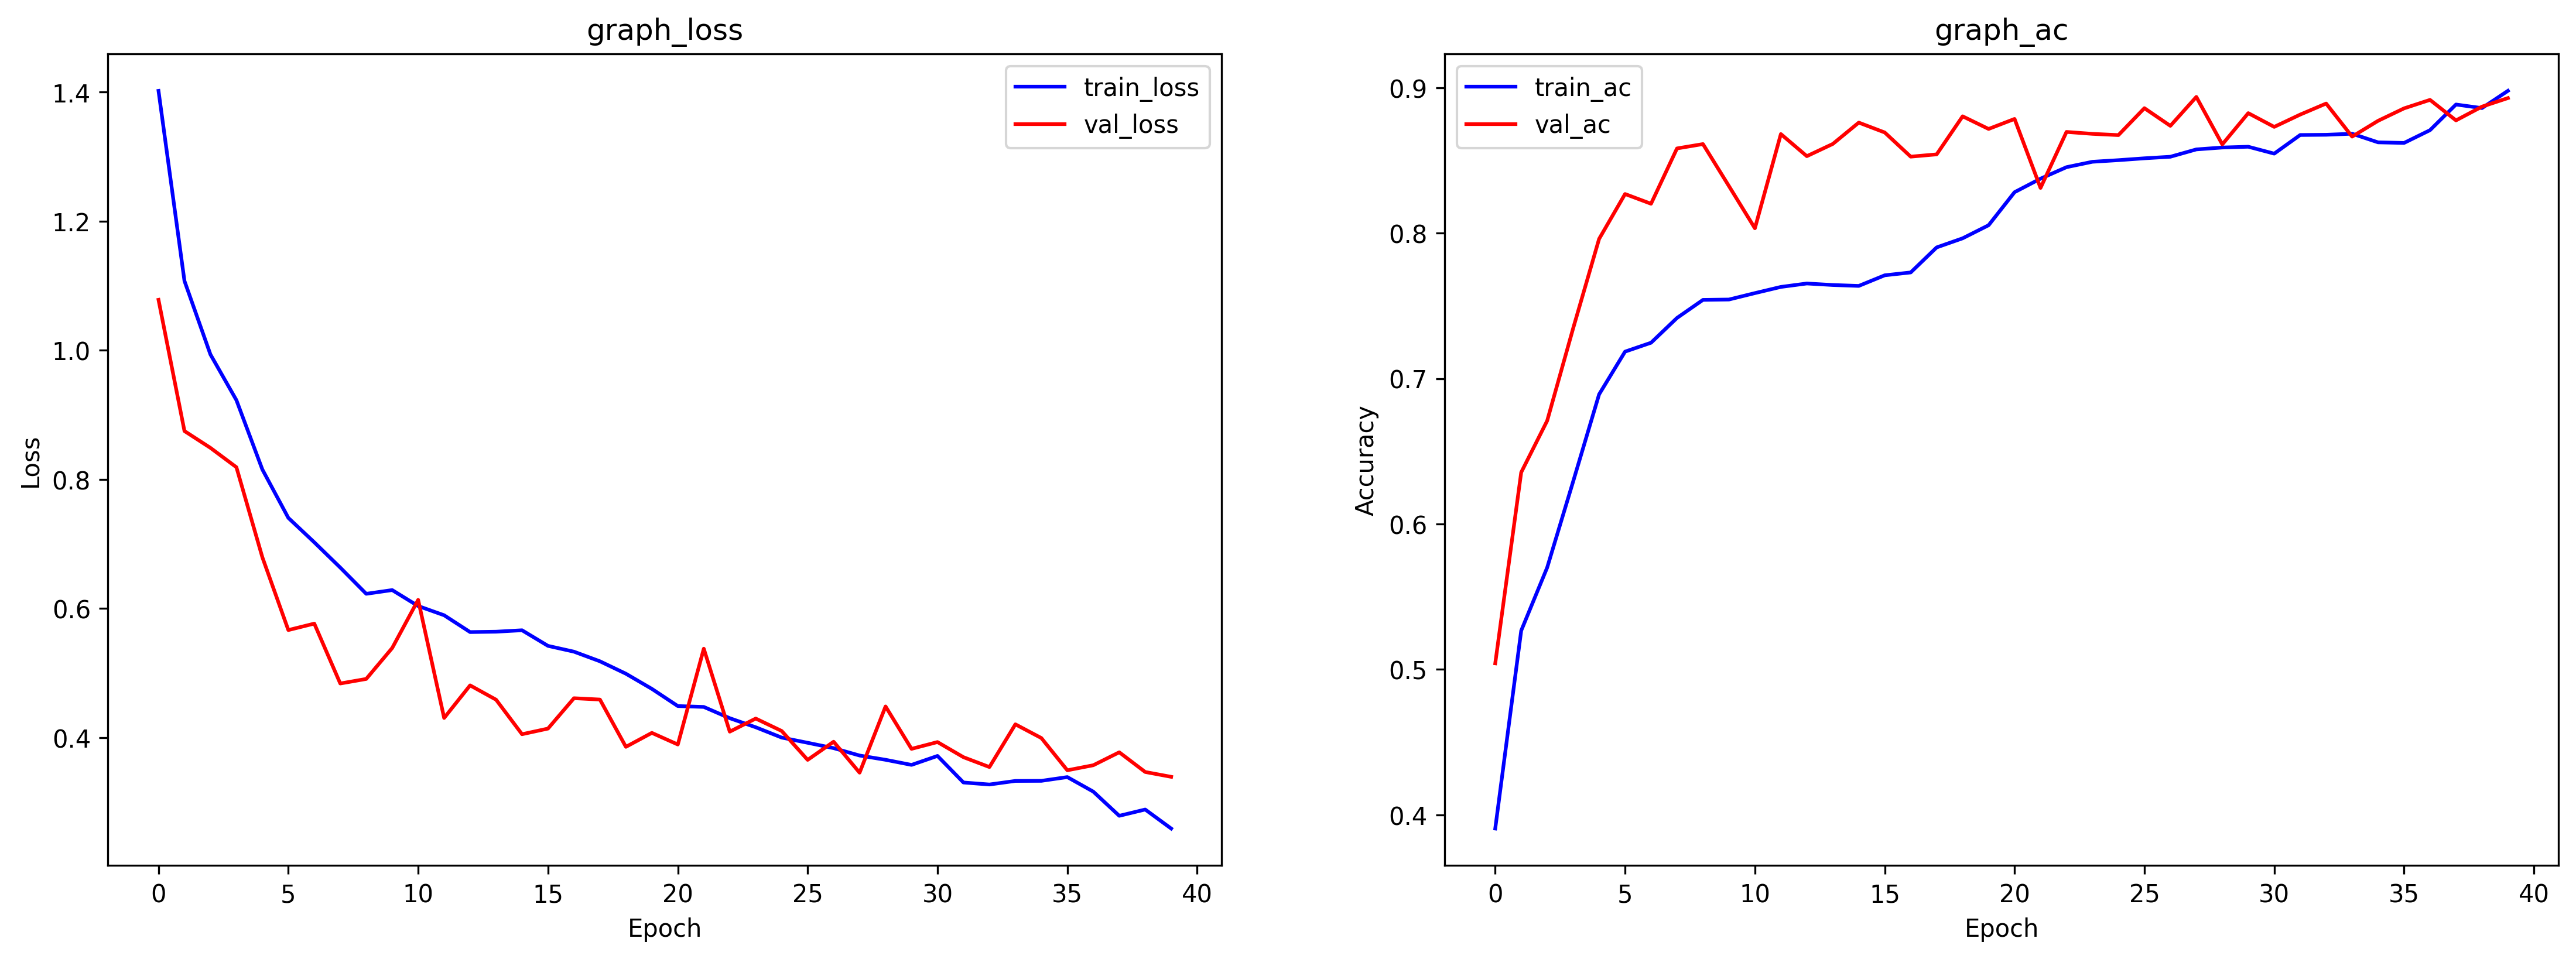

In [9]:
from matplotlib import pyplot as plt
plt.figure(dpi=300,figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(loss_train,color= 'blue', label= 'train_loss')
plt.plot(loss_val,color= 'red', label= 'val_loss')
plt.title('graph_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ac_train,color= 'blue', label= 'train_ac')
plt.plot(ac_val,color= 'red', label= 'val_ac')
plt.title('graph_ac')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test on the test_dataset

In [10]:
from sklearn.metrics import  precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
def test(model, test_iter, loss):   
    y_real = []
    y_pred = []
    total_loss = []
    
    model.load_state_dict(torch.load('save/3200100259/model_saved.pth'))
    model.to(device) 
    # 将模型设置为验证模式
    model.eval()
    
    with torch.no_grad():
        for X, y in test_iter:
            y_real.extend(np.array(y).tolist())
            X = X.to(device)
            y = y.to(device)
            y_hat,_ = model(X)
            l = loss(y_hat, y)
            total_loss.append(l.item())
            y_pred.extend(y_hat.argmax(dim=1).tolist())
            
            
    
    f1 = f1_score(y_true=y_real, y_pred=y_pred, average='macro')
    ac = accuracy_score(y_true=y_real, y_pred=y_pred)
    re = recall_score(y_true=y_real, y_pred=y_pred,average='macro')
    conf = confusion_matrix(y_true=y_real, y_pred=y_pred, labels=None, sample_weight=None)
    list_wrong = []
    for i in range(len(y_real)):
        if y_real[i] != y_pred[i] :
            list_wrong.append(i)
    
    return (sum(total_loss)/len(total_loss),f1,re,ac,conf,y_pred,list_wrong)
        

test_loss,test_f1,test_re,test_ac,test_conf,y_pred,list_wrong = test(model, test_loader, loss)
print('test_loss = %.2f'%test_loss)
print('test_f1 = %.2f'%test_f1)
print('test_recall = %.2f'%test_re)
print('test_accuracy = %.2f'%test_ac)
print('confusion_matrix:')
print(test_conf)

test_loss = 0.35
test_f1 = 0.89
test_recall = 0.89
test_accuracy = 0.89
confusion_matrix:
[[375   4   1   5   5  47]
 [  1 461   4   3   2   3]
 [  7   2 466  56  21   1]
 [  2   0  51 451  21   0]
 [  8   2  15  11 470   4]
 [ 33   3   3   4   3 455]]


In [11]:
#print model's state_dict
print('Model.state_dict:')
for param_tensor in model.state_dict():
    #打印 key value字典
    print(param_tensor,'\t',model.state_dict()[param_tensor].size())


Model.state_dict:
b1.0.weight 	 torch.Size([64, 3, 7, 7])
b1.0.bias 	 torch.Size([64])
b1.1.weight 	 torch.Size([64])
b1.1.bias 	 torch.Size([64])
b1.1.running_mean 	 torch.Size([64])
b1.1.running_var 	 torch.Size([64])
b1.1.num_batches_tracked 	 torch.Size([])
b2.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
b2.0.conv1.bias 	 torch.Size([64])
b2.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
b2.0.conv2.bias 	 torch.Size([64])
b2.0.bn1.weight 	 torch.Size([64])
b2.0.bn1.bias 	 torch.Size([64])
b2.0.bn1.running_mean 	 torch.Size([64])
b2.0.bn1.running_var 	 torch.Size([64])
b2.0.bn1.num_batches_tracked 	 torch.Size([])
b2.0.bn2.weight 	 torch.Size([64])
b2.0.bn2.bias 	 torch.Size([64])
b2.0.bn2.running_mean 	 torch.Size([64])
b2.0.bn2.running_var 	 torch.Size([64])
b2.0.bn2.num_batches_tracked 	 torch.Size([])
b2.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
b2.1.conv1.bias 	 torch.Size([64])
b2.1.conv2.weight 	 torch.Size([64, 64, 3, 3])
b2.1.conv2.bias 	 torch.Size([64])
b2.1.bn1.weight 	 to

# Show the heatmap

/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


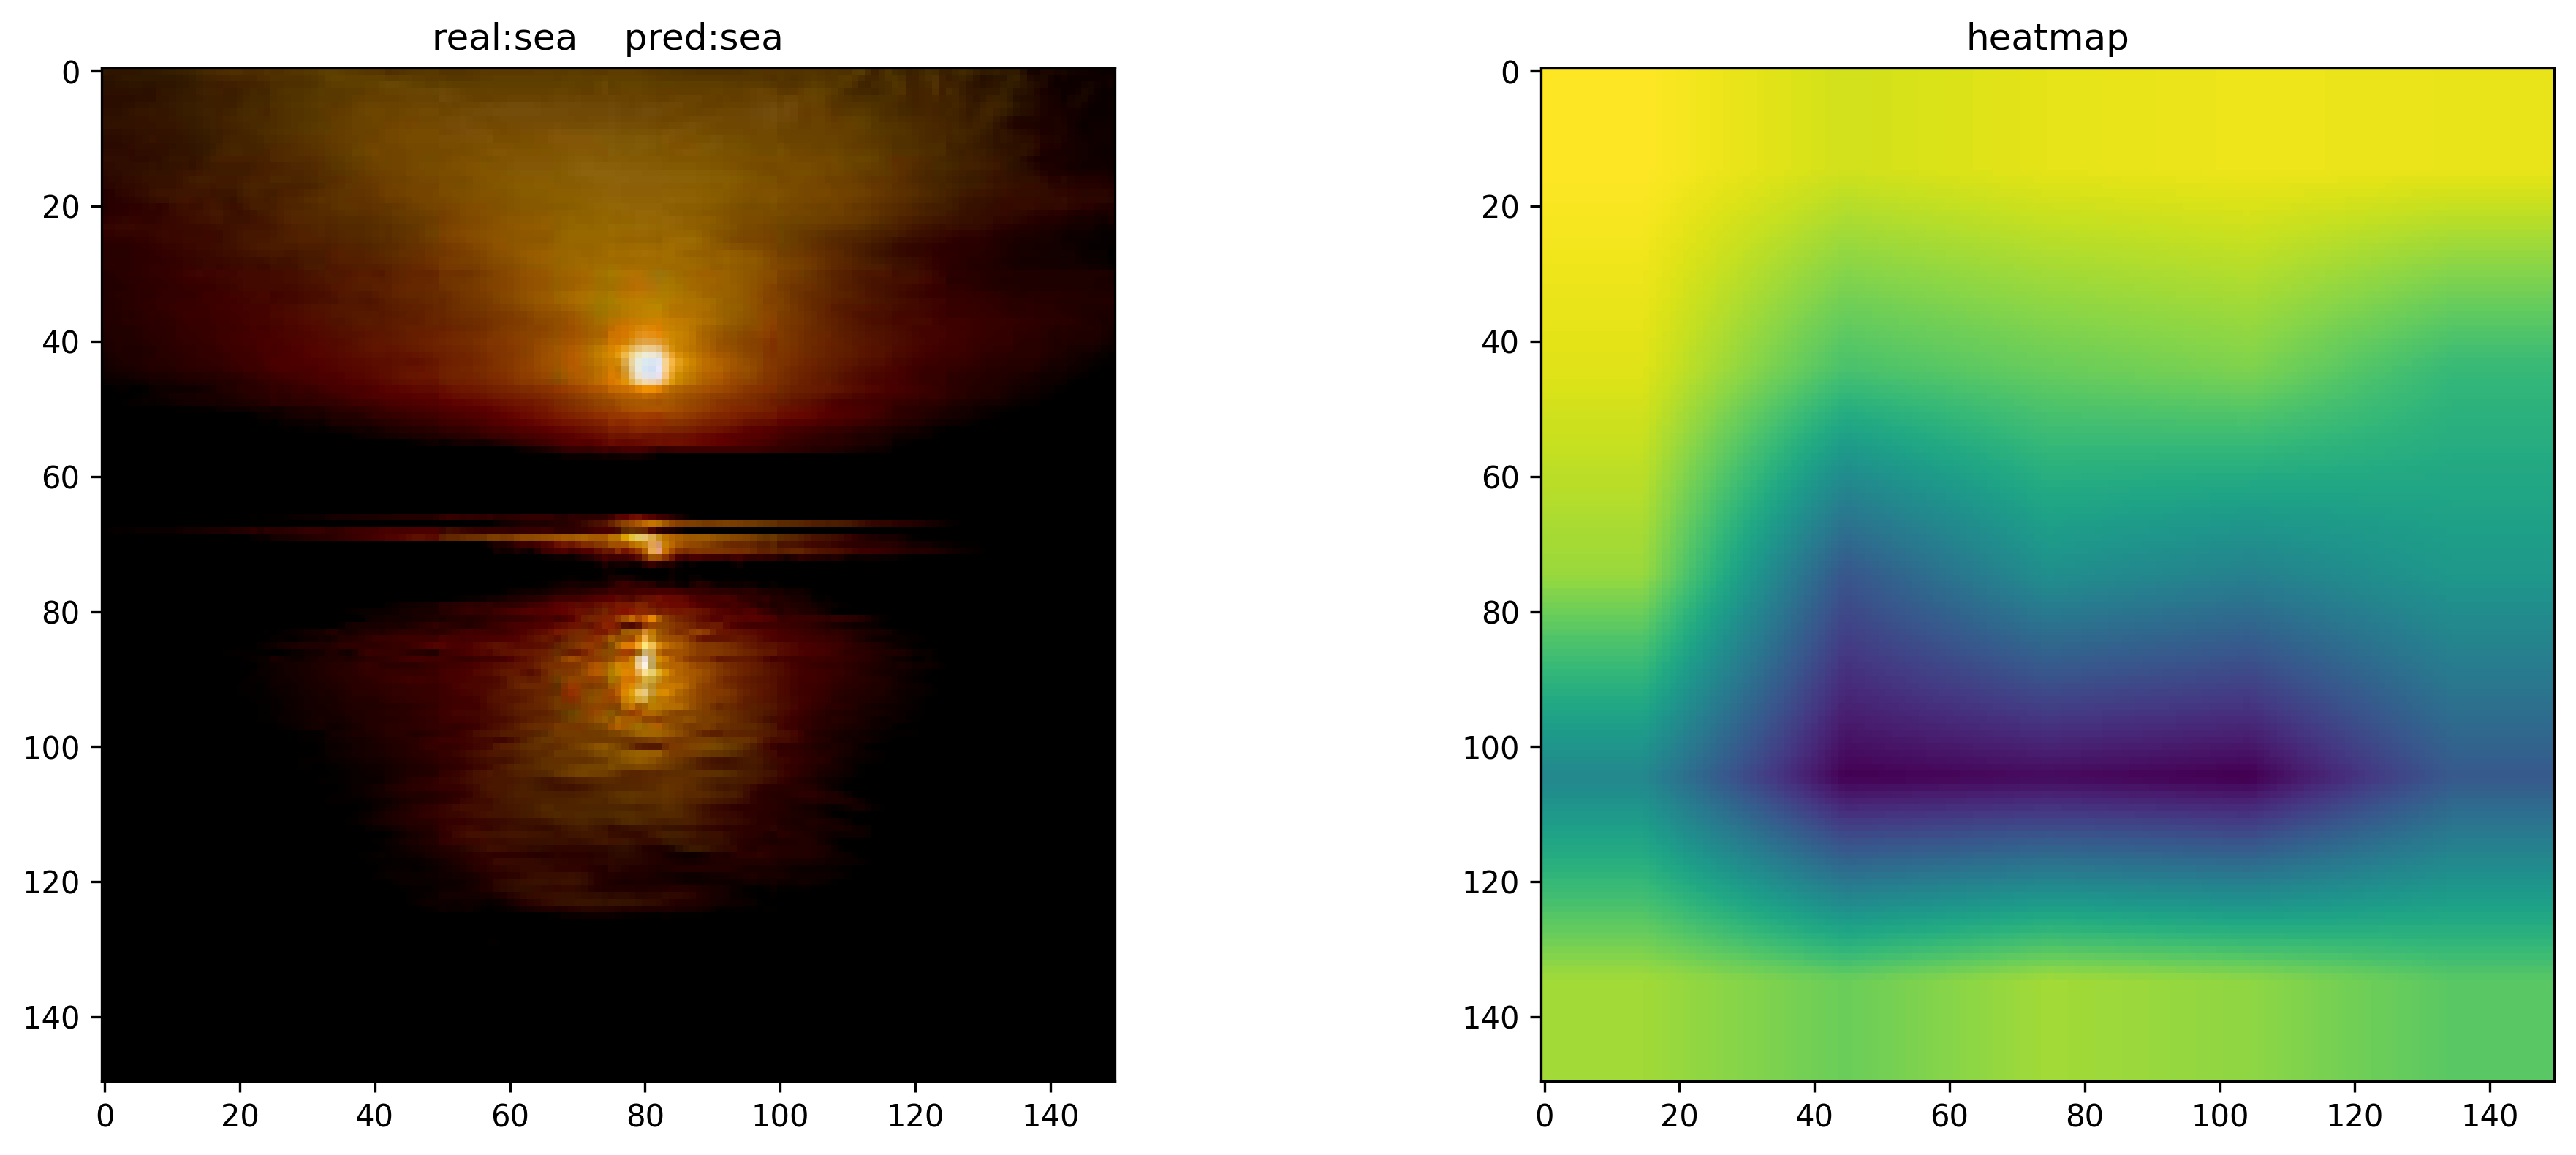

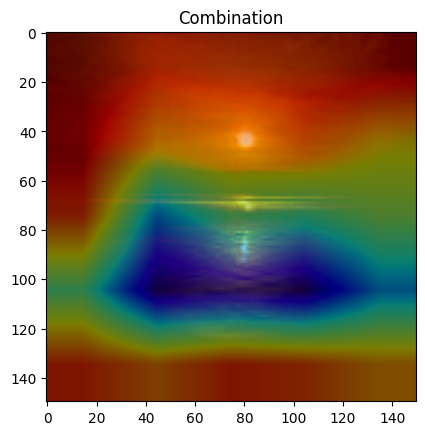

In [12]:
import cv2
i = np.random.randint(len(test_data))
img = test_data[i][0];
rlabel = test_data.classes[test_data[i][1]]
def heatmap(model, img):
    model.to('cpu')
    model.load_state_dict(torch.load('save/3200100259/model_saved.pth'))
    # 将模型设置为验证模式
    model.eval()
    with torch.no_grad():
        img = torch.tensor(img)
        img = img.unsqueeze(axis= 0)
        out,out2 = model(img)
        out = np.argmax(out.numpy())
    return out,out2

out,out2 = heatmap(model, img)
plabel = test_data.classes[out]
weight = model.state_dict()['linear.weight'][out,:]
out2 = out2.squeeze(dim = 0)
out2 = out2.numpy().transpose((1,2,0))
weight = weight.unsqueeze(dim = 1)

simg = img.numpy().transpose((1,2,0))# [C x H x W] 改变成 [H × W × C]
heatmap = cv2.resize(np.dot(out2,weight),(150,150))

plt.figure(dpi=300,figsize=(24,6))
plt.subplot(1,3,1)
plt.title('real:'+rlabel+'    pred:'+plabel)
plt.imshow(simg)# [C x H x W] 改变成 [H × W × C]

plt.subplot(1,3,2)
plt.title('heatmap')
plt.imshow(heatmap)

plt.subplots()
plt.title('Combination')
plt.imshow(simg)
plt.imshow(heatmap,cmap ='jet', alpha = 0.5)
plt.show()

# Training Log

调整batch_size/预处理函数/epoch
1. 采用残差网络取代传统的卷积架构 0.87
2. 在卷积层结束增加Dropout  0.88
2. 增加卷积层 无明显提升
3. 尝试attention--unit=128 0.89

从结果上看，应该继续训练可以提升。但是在后续训练中一直出现OOM的现象（模型参数未动），故只好作罢。